In [1]:
from tiger.io import read_image, write_image
from tiger.resampling import pad_or_crop_image
import numpy as np
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [2]:
img_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/input_extra_masks'
msk_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/output_extra_masks/vertebra_masks'
out_dir = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/fixed_extra_masks/'
img_paths = [os.path.join(img_dir, file) for file in sorted(os.listdir(img_dir))]
msk_paths = [os.path.join(msk_dir, file) for file in sorted(os.listdir(msk_dir)) if 'mha' in file]
out_paths = [os.path.join(out_dir, file) for file in sorted(os.listdir(out_dir)) if 'mha' in file]

verse011.mha img shape: (38, 289, 289), msk shape(40, 291, 287), cropped msk shape (38, 289, 289)


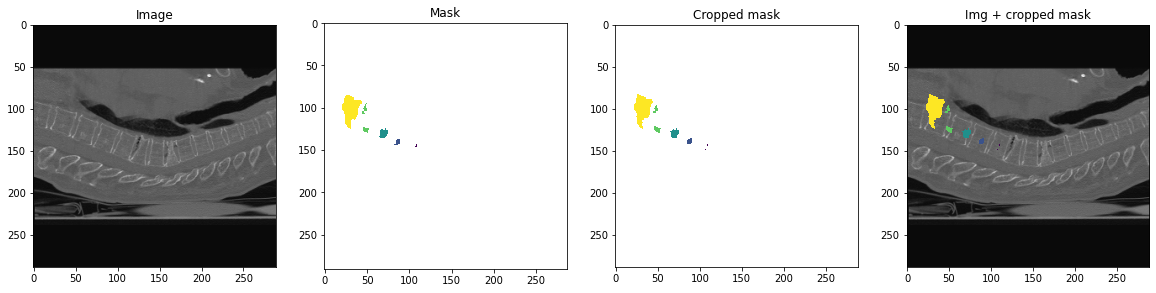

verse013.mha img shape: (109, 473, 616), msk shape(103, 473, 617), cropped msk shape (109, 473, 616)


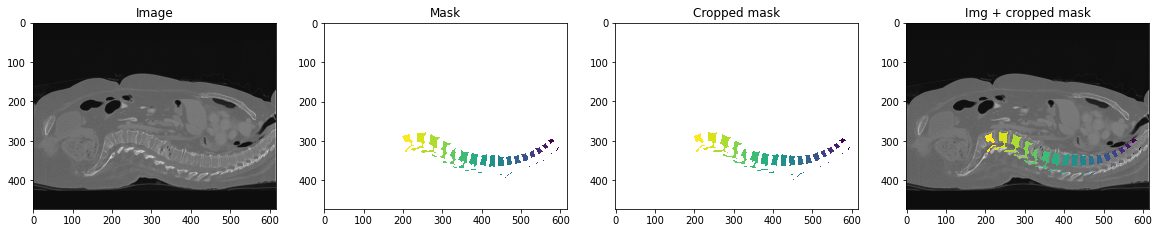

verse016.mha img shape: (48, 487, 633), msk shape(31, 487, 634), cropped msk shape (48, 487, 633)


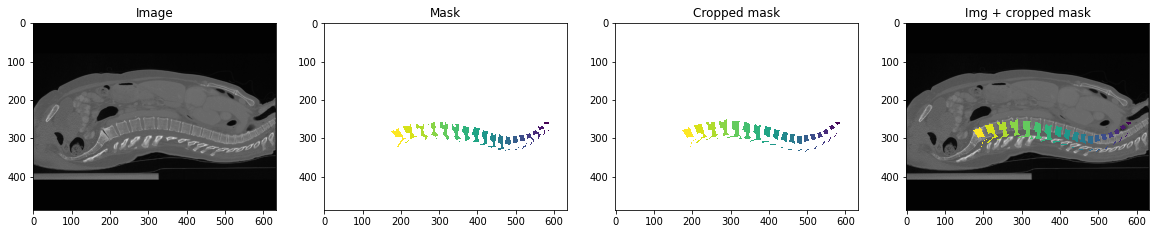

verse018.mha img shape: (100, 401, 522), msk shape(64, 406, 524), cropped msk shape (100, 401, 522)


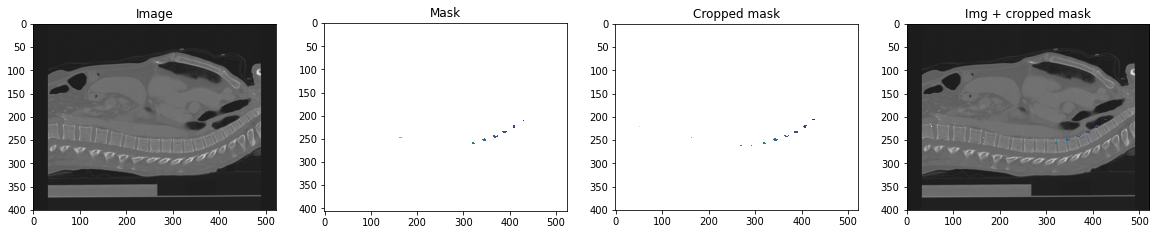

verse023.mha img shape: (67, 288, 288), msk shape(58, 290, 288), cropped msk shape (67, 288, 288)


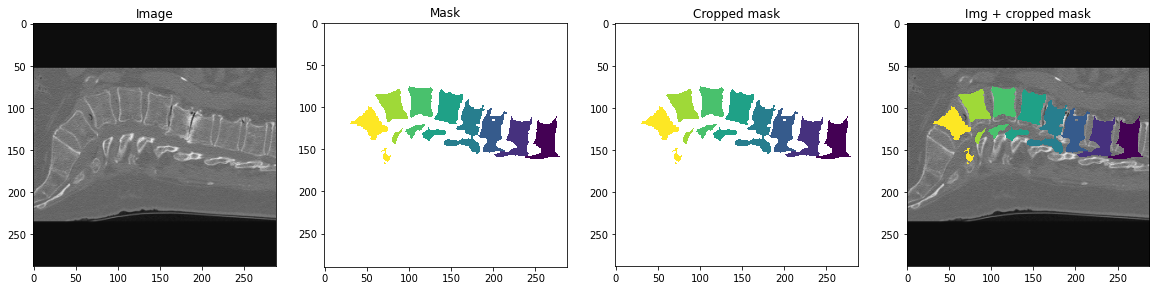

verse024.mha img shape: (73, 356, 356), msk shape(15, 362, 357), cropped msk shape (73, 356, 356)


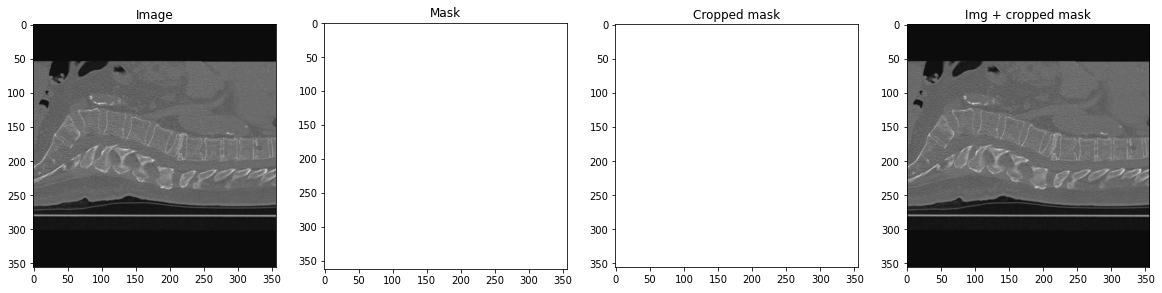

verse030.mha img shape: (59, 220, 220), msk shape(71, 218, 218), cropped msk shape (59, 220, 220)


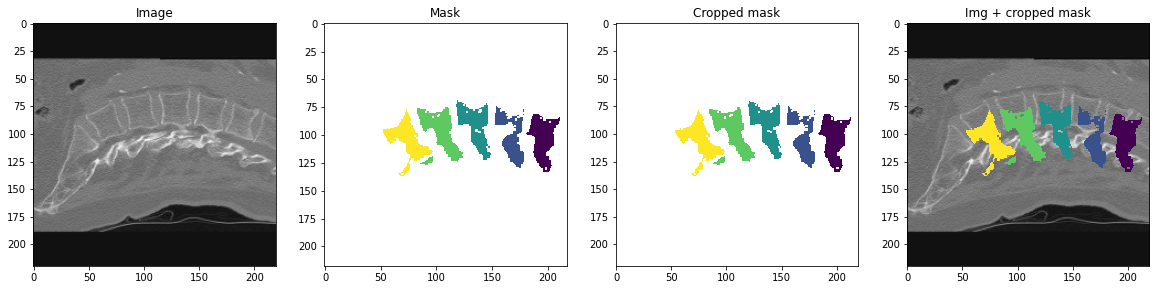

verse041.mha img shape: (96, 596, 776), msk shape(91, 602, 772), cropped msk shape (96, 596, 776)


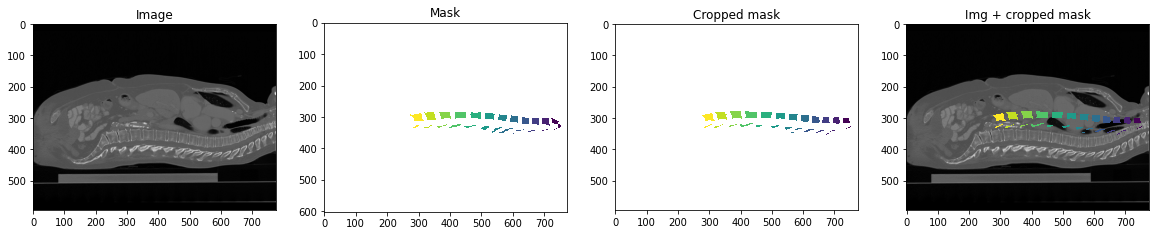

verse047.mha img shape: (71, 176, 509), msk shape(70, 171, 511), cropped msk shape (71, 176, 509)


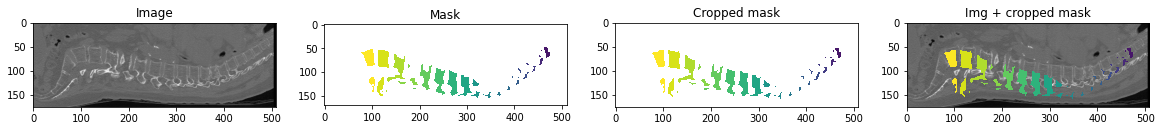

verse067.mha img shape: (52, 186, 471), msk shape(29, 191, 471), cropped msk shape (52, 186, 471)


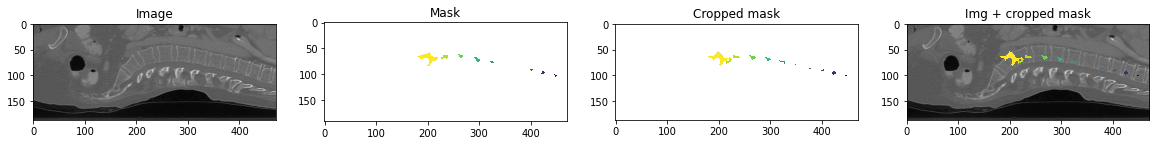

verse095.mha img shape: (96, 246, 593), msk shape(123, 253, 585), cropped msk shape (96, 246, 593)


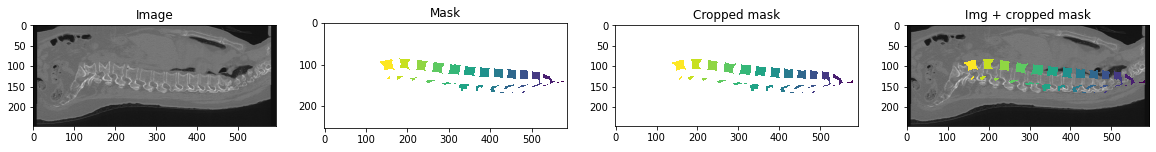

verse153.mha img shape: (66, 230, 367), msk shape(65, 277, 333), cropped msk shape (66, 230, 367)


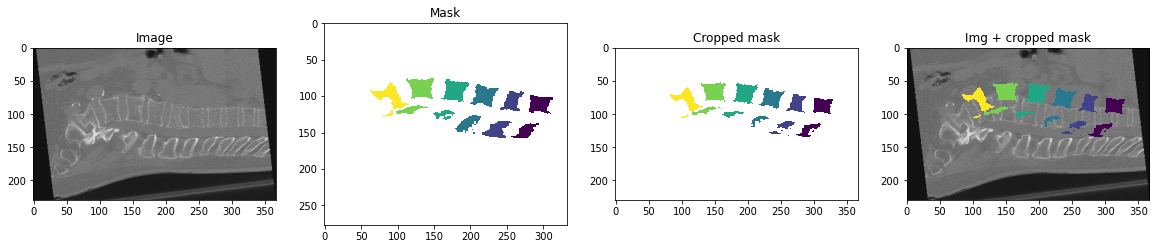

verse205.mha img shape: (41, 103, 157), msk shape(37, 24, 187), cropped msk shape (41, 103, 157)


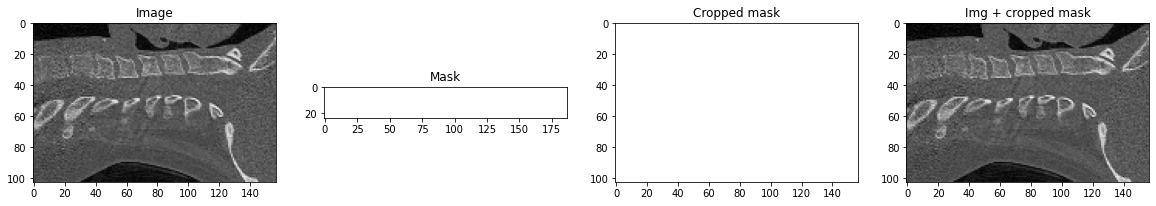

verse209.mha img shape: (74, 137, 214), msk shape(72, 134, 217), cropped msk shape (74, 137, 214)


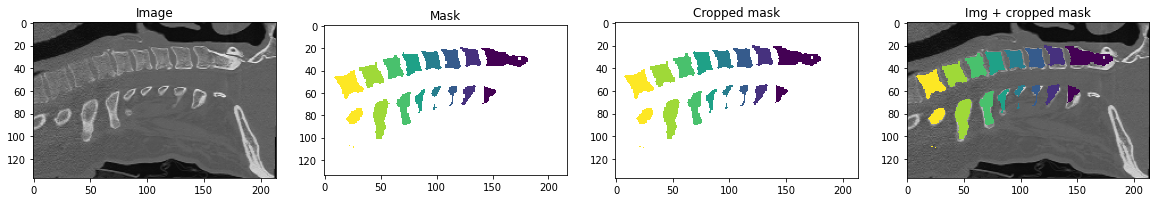

verse242.mha img shape: (67, 123, 242), msk shape(99, 44, 258), cropped msk shape (67, 123, 242)


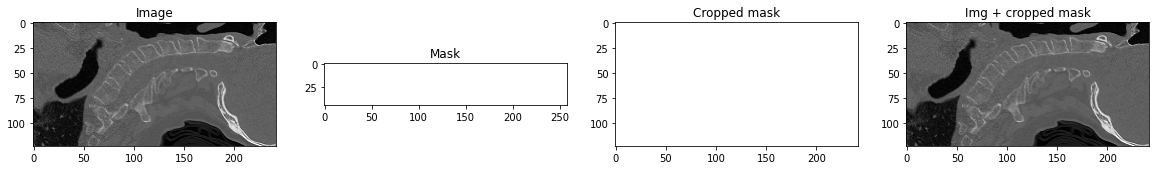

verse252.mha img shape: (49, 211, 702), msk shape(12, 211, 704), cropped msk shape (49, 211, 702)


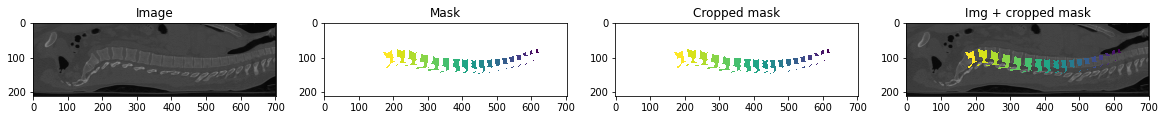

verse256.mha img shape: (86, 218, 667), msk shape(93, 215, 667), cropped msk shape (86, 218, 667)


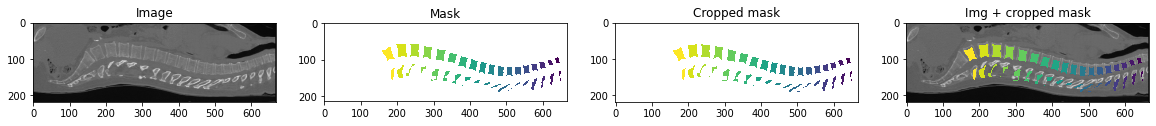

verse276.mha img shape: (61, 218, 613), msk shape(73, 218, 612), cropped msk shape (61, 218, 613)


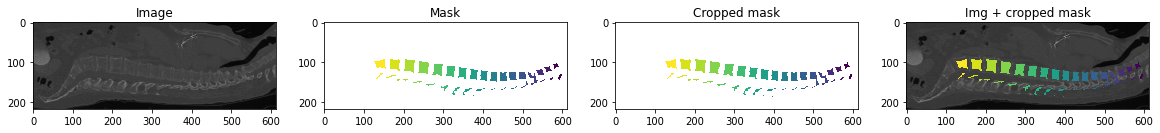

In [52]:
for img_path, msk_path in zip(img_paths, msk_paths):
    # read the image and the predicted mask
    img, header_img = read_image(img_path)
    msk, header_msk = read_image(msk_path)
    file_name = img_path.split('/')[-1]
    
    # filter out non C vertebrae, otherwise the vertebrae get the same color
    msk = np.where(msk < 26, msk, 0)
    plt_msk = np.ma.masked_where(msk == 0, msk)
    
    # mid slice of the image
    mid_slice_img = img.shape[0] // 2   
    mid_slice_msk = msk.shape[0] // 2 
    
    # if the shape are not the same, we will crop the mask to the target shape (shape of the orignal image)
    if not(img.shape == msk.shape):    
        cropped_msk = pad_or_crop_image(msk, img.shape)
        plt_msk_crop = np.ma.masked_where(cropped_msk == 0, cropped_msk)
        
        print("{} img shape: {}, msk shape{}, cropped msk shape {}".format(file_name, img.shape, msk.shape, cropped_msk.shape))
        plt.figure(figsize=(20,10))
        plt.subplot(1, 4, 1)
        plt.imshow(img[mid_slice_img, :, :], cmap='gray')
        plt.title('Image')
        
        plt.subplot(1, 4, 2)
        plt.imshow(plt_msk[mid_slice_msk, :, :])
        plt.title('Mask')
        
        plt.subplot(1, 4, 3)
        plt.imshow(plt_msk_crop[mid_slice_img, :, :])
        plt.title('Cropped mask')
        
        plt.subplot(1, 4, 4)
        plt.imshow(img[mid_slice_img, :, :], cmap='gray')
        plt.imshow(plt_msk_crop[mid_slice_img, :, :])
        plt.title('Img + cropped mask')
        plt.show()